Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [0]:
# Work from previous assignment
%%capture
import pandas as pd
import sys
from sklearn.model_selection import train_test_split

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# Read data
url = 'https://raw.githubusercontent.com/doinalangille/DS-Unit-2-Applied-Modeling/master/data/online_shoppers_intention.csv'
df = pd.read_csv(url)

# Delete outliers - the last 1%
cols = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues']

for c in cols:
  if (c=='ProductRelated_Duration'):
    condition = df[c] <= (max(df[c]) - max(df[c])*0.35)
    df = df[condition]
  else:
    condition = df[c] <= (max(df[c]) - max(df[c])*0.01)
    df = df[condition]

# Use random split, because data is provided for just one year, and it is possible to lose valuable insights if splitting by month
# Split dataframe into train & test
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Revenue'], random_state=42)
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Revenue'], random_state=42)

In [2]:
train.shape, val.shape, test.shape

((7433, 18), (1859, 18), (2324, 18))

### Feature Engineering

In [3]:
train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
10587,5,59.527778,3,124.25,156,5189.960659,0.001235,0.008929,20.509638,0.0,Nov,2,2,7,1,Returning_Visitor,False,True
6787,8,161.668571,0,0.00,518,11976.721350,0.000038,0.003837,0.000000,0.0,Oct,4,2,9,2,Returning_Visitor,False,False
4625,0,0.000000,0,0.00,7,38.000000,0.142857,0.171429,0.000000,0.0,May,2,2,2,13,Returning_Visitor,False,False
3365,5,436.000000,0,0.00,7,26.000000,0.066667,0.075000,0.000000,0.0,May,3,2,2,13,Returning_Visitor,False,False
950,0,0.000000,0,0.00,42,1185.666667,0.000000,0.004762,0.000000,0.0,Mar,2,2,1,1,Returning_Visitor,False,False


The variable **"Special Day"** is the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

In [0]:
# Define a function to wrangle the data sets in the same way

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # The dataset contains 125 duplicate rows
    # Keep only one unique row
    X.drop_duplicates(keep='first', inplace=True)

    # Some variables have to be categorical, not numerical
    # Transform them into strings
    cols_to_string = ['SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
    X[cols_to_string] = X[cols_to_string].astype(str)

    # Make a new feature to group all the scores based on either it was or not close to a holiday
    X.loc[X['SpecialDay'] == 0, 'HolidayPeriod'] = 0
    X.loc[X['SpecialDay'] != 0, 'HolidayPeriod'] = 1

    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

### Baselines for classification

In [5]:
# My target to predict is Revenue
# Determine the majority class
train['Revenue'].value_counts(normalize=True)

False    0.836271
True     0.163729
Name: Revenue, dtype: float64

In [7]:
# What is the majority class for every prediction?
y_train = train['Revenue']
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
pd.unique(y_pred), len(y_pred)

(array([False]), 7433)

In [8]:
# Get validation recall and precision for the baseline for classification
from sklearn.metrics import classification_report

y_val = val['Revenue']
y_pred = [majority_class] * len(val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.84      1.00      0.91      1555
        True       0.00      0.00      0.00       304

    accuracy                           0.84      1859
   macro avg       0.42      0.50      0.46      1859
weighted avg       0.70      0.84      0.76      1859



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### First model

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Arrange data into X features matrix and y target vector
target = 'Revenue'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    RandomForestClassifier(n_estimators=25, random_state=42, n_jobs=-1)
)

In [10]:
# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

# Get precision and recall
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.97      0.94      1555
        True       0.76      0.46      0.57       304

    accuracy                           0.89      1859
   macro avg       0.83      0.72      0.75      1859
weighted avg       0.88      0.89      0.88      1859



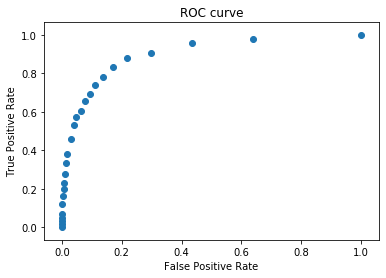

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)

# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [13]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9011179979691994